# Decision trees with categoricals
Most CS data will be categorical (category of need, ethnicity, etc.). SKlearn decision trees don't like categoricals, but we don't want to drop them as it's really useful data. What we can do instead is encode them into extra columns as 1s and 0s, which the decision tree can accept and make use of (although it is very computationally expensive). For instance, ethnicity codes in a table might be something like WIRI, BOTH, AOTH. We can encode these so that each unique variable in the column becomes a seprate column with a 1 in a row if it was in the original row, and a 0 if it wasn't. So, if a child was WIRI, they would have a 1 in the WIRI column and a 0 in both of the BOTH and AOTH columns. We can do this with the SKLearn one-hot-encode function.

In [151]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

characteristics = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/ChildCharacteristics.csv')
identifiers = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/ChildIdentifiers.csv')
cpps = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/CINdetails.csv')


I want to find out what characteristics are associated with a CP plan, so I need to work out a way to join every child's characteristics to the CP table, BUT, the CP table has multiple entries for each child. For simplicity, I'll look for what characteristics children with at least ONE CP plan have. To do this, I'll take the cpps table and drop duplicates of child id, so each child who has had a cp plan will have one row. I'll then make a column there and fill it with 1s (to be true) and drop all the columns except that and child id. When I merge that with identifiers, all children with at least one CP plan will have a 1 in their row, the others will have nothing. I'll then .fillna() those empty spaces with 0s.

In [152]:
char_ident = identifiers.merge(characteristics, how='left', on='LAchildID')
cpps.drop_duplicates('LAchildID', inplace=True)

cpps.drop(['Unnamed: 0', 
           'CINdetailsID', 
           'CINreferralDate', 
           'ReferralSource', 
           'PrimaryNeedCode', 
           'CINclosureDate', 
           'ReasonForClosure', 
           'DateOfInitialCPC', 
           'ReferralNFA'], 
           axis=1, 
           inplace=True)

In [153]:
cpps['CP plan'] = 1


df = char_ident.merge(cpps, how='left', on='LAchildID')
df['CP plan'].fillna(0, inplace=True)
df['CP plan'] = df['CP plan'].astype('int') # This is just because I prefer to look at ints over floats
df.drop(['Unnamed: 0_x', 'UPN', 'FormerUPN', 'UPNunknown', 'PersonBirthDate', 'PersonDeathDate', 'Unnamed: 0_y', 'ExpectedPersonBirthDate'], axis=1, inplace=True)

df

,LAchildID,GenderCurrent,Ethnicity,CP plan
0,RND000215205141,1,WIRT,1
1,RND000824303014,9,WROM,1
2,RND000750143123,1,AOTH,1
3,RND000909164501,0,MWBC,1
4,RND000382171815,2,APKN,1
...,...,...,...,...
327,RND000112711501,2,WOTH,0
328,RND000513120794,2,WROM,0
329,RND000541643134,1,BCRB,0
330,RND000404939452,2,AIND,0


In [154]:

def ethnicity_check(row):
    if row[0] == 'W':
        return 'white'
    if (row[0] == 'A' ) | (row[0] == 'C' ):
        return 'asian'
    if row[0] == 'M':
        return 'mixed'
    if row[0] == 'B':
        return 'black'
    else:
        return 'unknown'
    
def gender_check(row):
    if row == 1:
        return 'male'
    if row == 2:
        return 'female'
    else:
        return 'other'

    
df['Ethnicity'] = df['Ethnicity'].apply(ethnicity_check)
df['GenderCurrent'] = df['GenderCurrent'].apply(gender_check)

We can see that Gender (despite having a number code) and ethnicity are categorical, so we need to encode those!

In [155]:
df_encoded = pd.get_dummies(df[['GenderCurrent', 'Ethnicity']])
id_cp = df[['LAchildID', 'CP plan']]
full_encoded_df = id_cp.merge(df_encoded, how='left', left_index=True, right_index=True)
full_encoded_df

,LAchildID,CP plan,GenderCurrent_female,GenderCurrent_male,GenderCurrent_other,Ethnicity_asian,Ethnicity_black,Ethnicity_mixed,Ethnicity_unknown,Ethnicity_white
0,RND000215205141,1,False,True,False,False,False,False,False,True
1,RND000824303014,1,False,False,True,False,False,False,False,True
2,RND000750143123,1,False,True,False,True,False,False,False,False
3,RND000909164501,1,False,False,True,False,False,True,False,False
4,RND000382171815,1,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
327,RND000112711501,0,True,False,False,False,False,False,False,True
328,RND000513120794,0,True,False,False,False,False,False,False,True
329,RND000541643134,0,False,True,False,False,True,False,False,False
330,RND000404939452,0,True,False,False,True,False,False,False,False


In [156]:
#split dataset in features and target variable
feature_cols = ['GenderCurrent_female', 
                'GenderCurrent_male', 
                'GenderCurrent_other', 
                'Ethnicity_asian',
                'Ethnicity_white',
                'Ethnicity_black',
                'Ethnicity_mixed']
X = full_encoded_df[feature_cols] # Features
y = full_encoded_df['CP plan'] # Target variable

In [157]:
# best_acc = 0

# for criterion in "gini", "entropy":
#     for max_depth in [2,3,4,5,6]:
#         for min_samples_leaf in [5, 10, 20, 30]:
#             dtree = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
#             dtree.fit(X_train, y_train)
#             predicitions = dtree.predict(X_test)
#             acc = accuracy_score(y_test, predicitions)
#             if acc > best_acc:
#                 best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
#                 best_acc = acc

In [158]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
best_acc = 0

for criterion in "gini", "entropy":
    for max_depth in [2,3,4,5,6]:
        for min_samples_leaf in [5, 10, 20, 30]:
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = metrics.accuracy_score(y_test, y_pred)
            if acc > best_acc:
                best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                best_acc = acc

print(best_params)
clf = DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_leaf=5)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",best_acc)

criterion: gini, max_depth: 2, min_samples_leaf: 5
Accuracy: 0.77


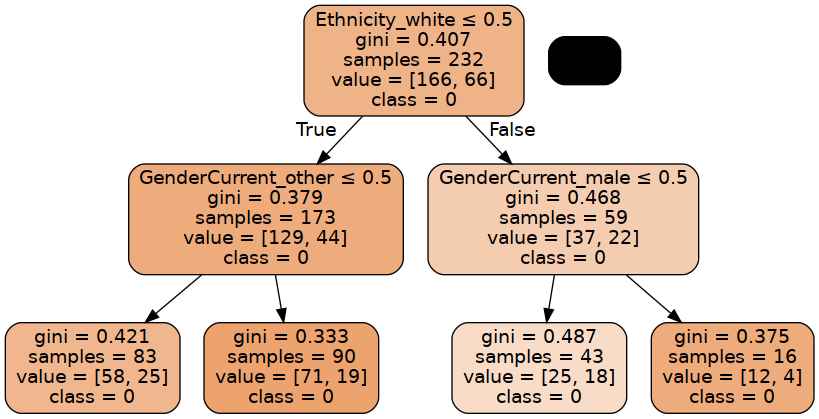

In [159]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('cp plans.png')
Image(graph.create_png())
